# Example 06 - TorchSigWideband with YOLOv8 Detector
This notebook showcases using the Wideband dataset to train a YOLOv8 model.

---

## Import Libraries

In [1]:
# Packages Imports for Training
from torchsig.utils.yolo_train import *
from datetime import datetime
import yaml

In [2]:
# Package Imports for Testing/Inference
from torchsig.datasets.datamodules import WidebandDataModule
from torchsig.datasets.signal_classes import torchsig_signals
from torchsig.transforms.transforms import Spectrogram, SpectrogramImage, Normalize, Compose, Identity
from torchsig.transforms.target_transforms import DescToBBoxFamilyDict
from ultralytics import YOLO
import torch
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os

-----------------------------
## Check or Generate the Wideband Dataset
To generate the TorchSigWideband dataset, several parameters are given to the imported `WidebandDataModule` class. These paramters are:
- `root` ~ A string to specify the root directory of where to generate and/or read an existing TorchSigWideband dataset
- `train` ~ A boolean to specify if the TorchSigWideband dataset should be the training (True) or validation (False) sets
- `qa` - A boolean to specify whether to generate a small subset of Wideband (True), or the full dataset (False), default is True
- `impaired` ~ A boolean to specify if the TorchSigWideband dataset should be the clean version or the impaired version
- `transform` ~ Optionally, pass in any data transforms here if the dataset will be used in an ML training pipeline. Note: these transforms are not called during the dataset generation. The static saved dataset will always be in IQ format. The transform is only called when retrieving data examples.
- `target_transform` ~ Optionally, pass in any target transforms here if the dataset will be used in an ML training pipeline. Note: these target transforms are not called during the dataset generation. The static saved dataset will always be saved as tuples in the LMDB dataset. The target transform is only called when retrieving data examples.

A combination of the `train` and the `impaired` booleans determines which of the four (4) distinct TorchSigWideband datasets will be instantiated:
| `impaired` | `qa` | Result |
| ---------- | ---- | ------- |
| `False` | `False` | Clean datasets of train=250k examples and val=25k examples |
| `False` | `True` | Clean datasets of train=250 examples and val=250 examples |
| `True` | `False` | Impaired datasets of train=250k examples and val=25k examples |
| `True` | `True` | Impaired datasets of train=250 examples and val=250 examples |

The final option of the impaired validation set is the dataset to be used when reporting any results with the official TorchSigWideband dataset.

In [3]:
# Generate TorchSigWideband DataModule
root = "./datasets/wideband"
impaired = True
qa = True
fft_size = 512
num_classes = len(torchsig_signals.class_list)
batch_size = 1

transform = Compose([    
])

target_transform = Compose([
    DescToBBoxFamilyDict()
])

datamodule = WidebandDataModule(
    root=root,
    impaired=impaired,
    qa=qa,
    fft_size=fft_size,
    num_classes=num_classes,
    transform=transform,
    target_transform=target_transform,
    batch_size=batch_size
)

In [4]:
datamodule.prepare_data()
datamodule.setup("fit")

wideband_train = datamodule.train

# Retrieve a sample and print out information
idx = np.random.randint(len(wideband_train))
data, label = wideband_train[idx]
print("Dataset length: {}".format(len(wideband_train)))
print("Data shape: {}".format(data.shape))
print("Label: {}".format(label))

Using WidebandImpairedTrainQAConfig for train.
Dataset already exists in ./datasets/wideband/wideband_impaired_train. Not regenerating
Using WidebandImpairedValQAConfig for val.
Dataset already exists in ./datasets/wideband/wideband_impaired_val. Not regenerating
Dataset length: 250
Data shape: (262144,)
Label: {'labels': tensor([0, 0, 0, 0, 0, 1, 1, 1, 5, 5, 5, 5, 5]), 'boxes': tensor([[0.0589, 0.6964, 0.1178, 0.0188],
        [0.2845, 0.7528, 0.1178, 0.0188],
        [0.5100, 0.6964, 0.1178, 0.0188],
        [0.7356, 0.6964, 0.1178, 0.0188],
        [0.9511, 0.7715, 0.0978, 0.0188],
        [0.0469, 0.3680, 0.0937, 0.0262],
        [0.4066, 0.3680, 0.0937, 0.0262],
        [0.7664, 0.3680, 0.0937, 0.0262],
        [0.2051, 0.2305, 0.0610, 0.0766],
        [0.4185, 0.2305, 0.0610, 0.0766],
        [0.6320, 0.2305, 0.0610, 0.0766],
        [0.8454, 0.2305, 0.0610, 0.0766],
        [0.3194, 0.1120, 0.6388, 0.0447]])}


## Prepare YOLO trainer and Model
Next, the datasets are rewritten to disk that is Ultralytics YOLO compatible. See [Ultralytics: Train Custom Data - Organize Directories](https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/#23-organize-directories) to learn more. 

Additionally, create a yaml file for dataset configuration. See [Ultralytics: Train Custom Data - Create dataset.yaml](https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/#21-create-datasetyaml)

Download desired YOLO model from [Ultralytics Models](https://docs.ultralytics.com/models/). We will use YOLOv8, specifically `yolov8n.pt`

---

### Explanation of the `overrides` Dictionary

The `overrides` dictionary is used to customize the settings for the Ultralytics YOLO trainer by specifying specific values that override the default configurations. The dictionary is imported from `wbdata.yaml`. However, you can customize in the notebook. See [Ultralytics Train Settings](https://docs.ultralytics.com/modes/train/#train-settings) to learn more.

Example:

```python
overrides = {'model': 'yolov8n.pt', 'epochs': 100, 'data': 'wbdata.yaml', 'device': 0, 'imgsz': 512, 'single_cls': True}
```
A .yaml is necessary for training. Look at `06_yolo.yaml` in the examples directory. It will contain the path to your torchsig data.


### Dataset Location Warning

There must exist a datasets directory at `/path/to/torchsig/datasets`.

This example assumes that you have generated `train` and `val` lmdb wideband datasets at `./datasets/wideband/`

You can also specify an absolute path to your dataset in `06_yolo.yaml`.

In [5]:
# define dataset variables for yaml file
config_name = "06_yolo.yaml"
class_list = ["ask", "fsk", "ofdm", "pam", "psk", "qam"]
classes = {v: k for v, k in enumerate(class_list)}
num_classes = len(classes)
yolo_root = "./wideband/" # train/val images (relative to './datasets``

# define overrides
# Note: You can change use of GPU(s) or CPU by overriding the device
# GPU: device=0 or device=0,1
# CPU: device="cpu"
overrides = dict(
    model = "yolov8n.pt",
    project = "yolo",
    name = "06_example",
    epochs = 10,
    imgsz = 512,
    data = config_name,
    device = 0 if torch.cuda.is_available() else "cpu",
    single_cls = True,
    batch = 32,
    workers = 8

)

# create yaml file for trainer
yolo_config = dict(
    overrides = overrides,
    train = yolo_root,
    val = yolo_root,
    nc = num_classes,
    names = classes
)

with open(config_name, 'w+') as file:
    yaml.dump(yolo_config, file, default_flow_style=False)

print(f"Creating experiment -> {overrides['name']}")
    

Creating experiment -> 06_example


In [6]:
trainer = Yolo_Trainer(overrides=overrides)

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

## Train
Train YOLO. See [Ultralytics Train](https://docs.ultralytics.com/modes/train/#train-settings) for training hyperparameter options.

---

In [7]:
trainer.train()

TensorBoard: Start with 'tensorboard --logdir yolo/06_example2', view at http://localhost:6006/
Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.

2025/01/10 12:16:46 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
2025/01/10 12:16:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for pytorch_lightning.
2025/01/10 12:16:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/01/10 12:16:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


MLflow: logging run_id(76733d68ac9a4ab185473389dcac16d2) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to yolo/06_example2
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.83G      3.027      4.557      2.067        129        512: 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.42it/s]

                   all        250       1116    0.00558       0.14    0.00427    0.00166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.81G       2.49      4.286      1.768         91        512: 100%|██████████| 8/8 [00:00<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.64it/s]

                   all        250       1116     0.0125      0.303     0.0428      0.019



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.81G      1.624      3.583      1.243        101        512: 100%|██████████| 8/8 [00:00<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.05it/s]

                   all        250       1116     0.0156      0.375      0.114     0.0553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10       2.8G      1.504      2.784      1.169        102        512: 100%|██████████| 8/8 [00:00<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.55it/s]

                   all        250       1116     0.0204      0.514      0.141     0.0647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10       2.8G      1.468      2.172      1.103         94        512: 100%|██████████| 8/8 [00:00<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.37it/s]

                   all        250       1116       0.02      0.634      0.234      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.81G      1.465      1.826      1.105        104        512: 100%|██████████| 8/8 [00:00<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.96it/s]


                   all        250       1116     0.0182      0.583      0.287      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.81G      1.343      1.582      1.064        143        512: 100%|██████████| 8/8 [00:00<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.02it/s]

                   all        250       1116      0.018      0.592      0.343      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.82G      1.255      1.405      1.047        110        512: 100%|██████████| 8/8 [00:00<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.84it/s]

                   all        250       1116      0.023       0.69      0.395      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.82G      1.203      1.399      1.043        117        512: 100%|██████████| 8/8 [00:00<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.40it/s]

                   all        250       1116     0.0278      0.785      0.417      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.82G      1.184      1.304      1.025        101        512: 100%|██████████| 8/8 [00:00<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.00it/s]

                   all        250       1116     0.0309      0.865      0.459      0.292



10 epochs completed in 0.007 hours.
Optimizer stripped from yolo/06_example2/weights/last.pt, 5.6MB
Optimizer stripped from yolo/06_example2/weights/best.pt, 5.6MB

Validating yolo/06_example2/weights/best.pt...
Ultralytics 8.3.3 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090 Laptop GPU, 15981MiB)
Model summary (fused): 186 layers, 2,685,538 parameters, 0 gradients, 6.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


                   all        250       1116     0.0308      0.864      0.458      0.292
                   ask        250       1116     0.0308      0.864      0.458      0.292
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to yolo/06_example2
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


## Evaluation
Check model performance from training. From here, you can use the trained model to test on prepared data (numpy image arrays of spectrograms)

Will load example from Torchsig

model_path is path to best.pt from your training session. Path is printed at the end of training.

---

## Generate and Instantiate Wideband Test Dataset
After generating the Wideband dataset (see `03_example_widebandsig_dataset.ipynb`), we can instantiate it with the needed transforms. Change `root` to test dataset path.

---

In [8]:
test_path = './datasets/wideband_test' #Should differ from your training dataset

transform = Compose([
    Spectrogram(nperseg=512, noverlap=0, nfft=512, mode='psd'),
    Normalize(norm=np.inf, flatten=True),
    SpectrogramImage(), 
    ])

test_data = WidebandDataModule(
    root=test_path,
    impaired=impaired,
    qa=qa,
    fft_size=fft_size,
    num_classes=num_classes,
    transform=transform,
    target_transform=None,
    batch_size=batch_size
)

test_data.prepare_data()
test_data.setup("fit")

wideband_test = test_data.train

# Retrieve a sample and print out information
idx = np.random.randint(len(wideband_test))
data, label = wideband_test[idx]
print("Dataset length: {}".format(len(wideband_test)))
print("Data shape: {}".format(data.shape))

samples = []
labels = []
for i in range(10):
    idx = np.random.randint(len(wideband_test))
    sample, label = wideband_test[idx]
    lb = [l['class_name'] for l in label]
    samples.append(sample)
    labels.append(lb)

Using WidebandImpairedTrainQAConfig for train.
Dataset already exists in ./datasets/wideband_test/wideband_impaired_train. Not regenerating
Using WidebandImpairedValQAConfig for val.
Dataset already exists in ./datasets/wideband_test/wideband_impaired_val. Not regenerating
Dataset length: 250
Data shape: (512, 512, 3)


### Load model 
The model path is printed after training. Use the best.pt weights

In [9]:
model = YOLO(trainer.best)

In [10]:
# Inference will be saved to path printed after predict. 
results = model.predict(samples, save=True, imgsz=512, conf=0.5)


0: 512x512 (no detections), 3.5ms
1: 512x512 (no detections), 3.5ms
2: 512x512 (no detections), 3.5ms
3: 512x512 (no detections), 3.5ms
4: 512x512 (no detections), 3.5ms
5: 512x512 (no detections), 3.5ms
6: 512x512 (no detections), 3.5ms
7: 512x512 (no detections), 3.5ms
8: 512x512 (no detections), 3.5ms
9: 512x512 (no detections), 3.5ms
Speed: 0.9ms preprocess, 3.5ms inference, 0.1ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict2


In [11]:
%matplotlib inline

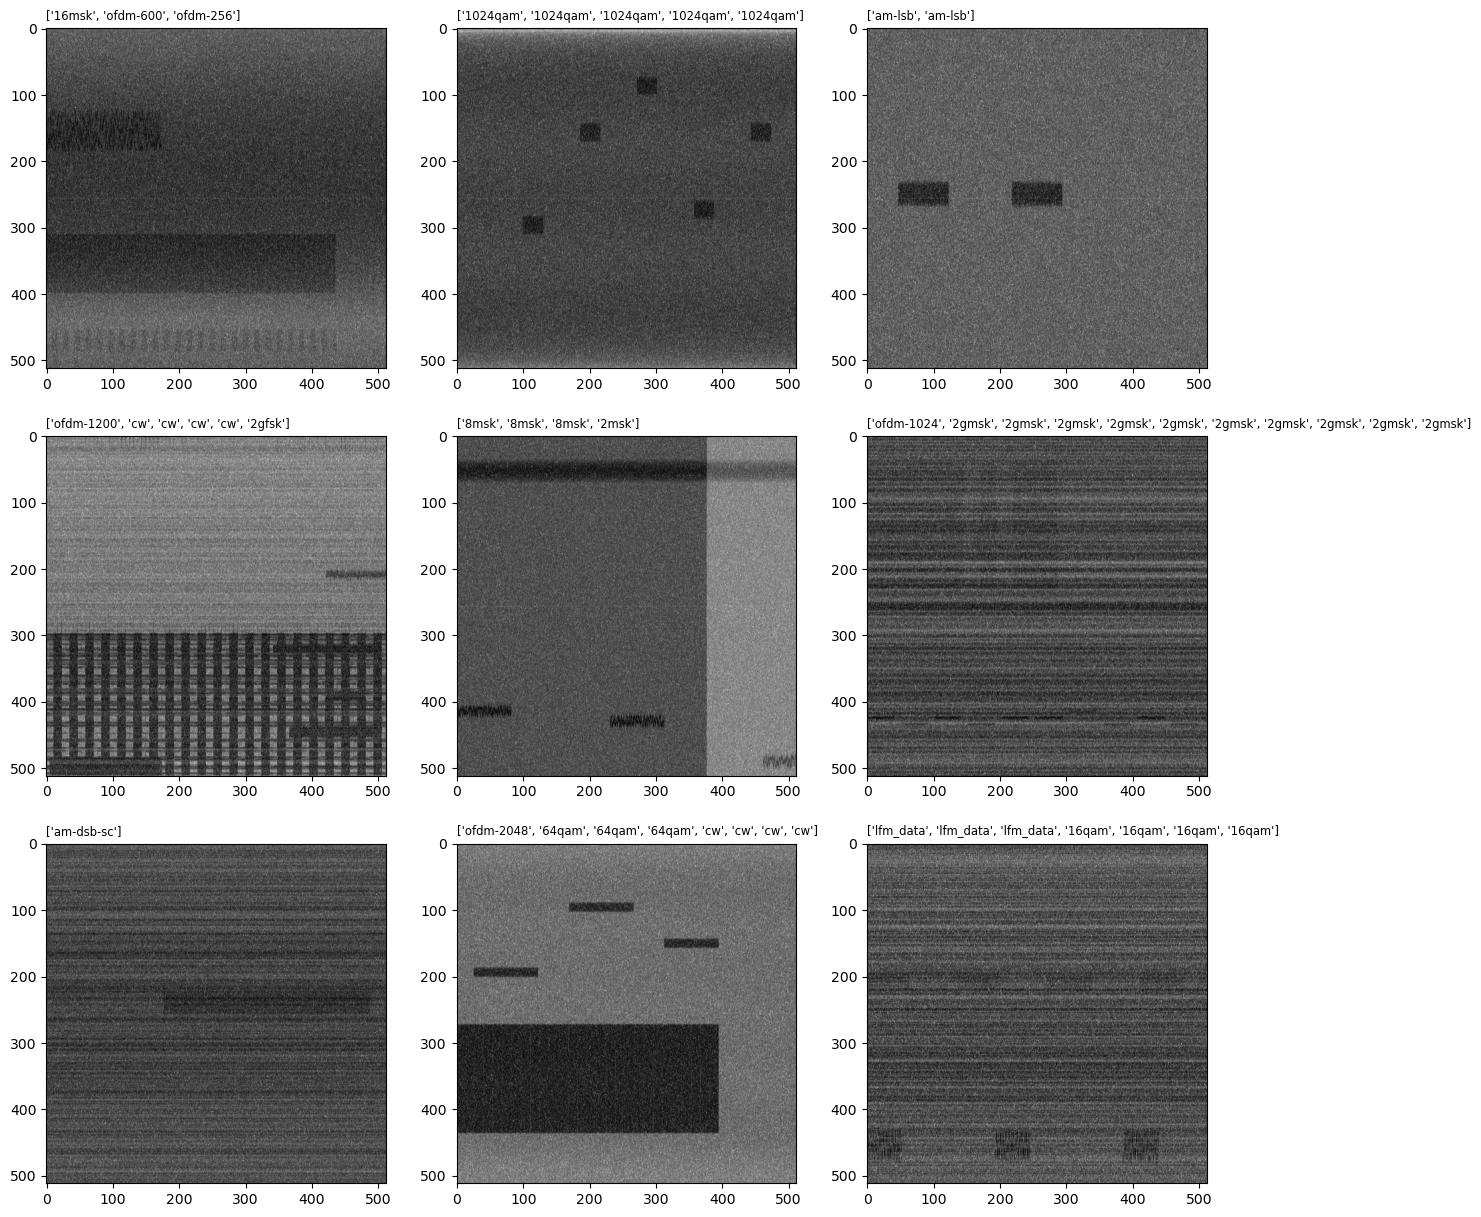

In [12]:
# Plot prediction results
rows = 3
cols = 3
fig = plt.figure(figsize=(15, 15)) 
results_dir = results[0].save_dir

for y, result in enumerate(results[:9]):
    imgpath = os.path.join(results_dir, "image" + str(y) + ".jpg")
    fig.add_subplot(rows, cols, y + 1) 
    img = cv2.imread(imgpath)
    plt.imshow(img)
    plt.title(str(labels[y]), fontsize='small', loc='left')